In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, random
from collections import deque
from scipy.stats import norm
from scipy.stats import binom, poisson, expon, geom
from statsmodels.stats.weightstats import ztest
from scipy.stats import norm, ttest_ind, ttest_rel, ttest_1samp
from scipy.stats import chi2, chi2_contingency, chisquare
from scipy.stats import f_oneway as anova_1way

from scipy.stats import kruskal # numeric Vs catogerical
from scipy.stats import pearsonr, spearmanr # numeric Vs numeric
from scipy.stats import kstest # cdf
from scipy.stats import levene
from scipy.stats import norm

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.gofplots import qqplot, qqplot_2samples
from scipy.stats import skew, shapiro #[Test for normality]

# Business Case - Jamboree Education - Linear Regression

# INDEX
- (A) Problem Statements
- (B) shape, duplicates and null values
- (C) Column Profiling
- (D) Checking outliers
- (E) Univariate Analysis
- (F) Bivariate Analysis
- (G) Linear regression model
- (H) Assumptions of linear regression
- (I) Testing VIF
- (J) Ridge regression with k-cross-validation
- (K) Lasso regression with k-cross-validation
- (L) Actionable insights
- (M) Recommendations

# (A) Problem Statements:-

<strong>How can you help here?</strong><br>

- Your analysis will help Jamboree in understanding what factors are important in graduate admissions and how these factors are interrelated among themselves. 
- It will also help predict one's chances of admission given the rest of the variables.

# (B) shape, duplicates and null values

In [3]:
Data = pd.read_csv("D:\Python programmes\Data Collection\Jamboree_Admission.csv")

In [4]:
df = Data.copy(deep=True)

In [5]:
df.shape

(500, 9)

In [6]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [7]:
df.drop(columns="Serial No.", inplace=True)

In [8]:
df.tail()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73
499,327,113,4,4.5,4.5,9.04,0,0.84


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [10]:
for col in df.columns:
    print(col,": ",df[col].nunique())

GRE Score :  49
TOEFL Score :  29
University Rating :  5
SOP :  9
LOR  :  9
CGPA :  184
Research :  2
Chance of Admit  :  61


### checking and removing duplicates

In [11]:
df.duplicated().sum()

0

### percentage data missing in each columns

In [12]:
#percentage data missing in each columns
L = df.shape[0]
for col in df.columns:
    p = df[col].isnull().sum()/L*100
    print(col, ": ",round(p,3),"%")

GRE Score :  0.0 %
TOEFL Score :  0.0 %
University Rating :  0.0 %
SOP :  0.0 %
LOR  :  0.0 %
CGPA :  0.0 %
Research :  0.0 %
Chance of Admit  :  0.0 %


# (C) Column Profiling

- Serial No. (Unique row ID)
- GRE Scores (out of 340)
- TOEFL Scores (out of 120)
- University Rating (out of 5)
- SOP:Statement of Purpose Strength (out of 5) 
- LOR: Letter of Recommendation Strength (out of 5)
- Undergraduate CGPA (out of 10)
- Research Experience (either 0 or 1)
- Chance of Admit (ranging from 0 to 1)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


# (D) Checking outliers

### <mark>creating a function to remove outliers from a given array (using IQR method)</mark>

In [14]:
def remove_outliers(arr):
    IQR = np.quantile(arr, 0.75)-np.quantile(arr, 0.25)
    LL = np.quantile(arr, 0.25)-1.5*IQR
    UL = np.quantile(arr, 0.75)+1.5*IQR
    arr = arr[arr>LL]
    arr = arr[arr<UL]
    return (arr)

In [15]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [16]:
# 1space found at the end of 'Chance of Admit '

In [17]:
df.columns = [x.strip() for x in df.columns]

In [18]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

### outliers% in columns

In [19]:
for col in ("GRE Score","TOEFL Score","CGPA","Chance of Admit"):
    arr = df[col].values; N=len(arr)
    percnt = (N-len(remove_outliers(arr)))/N*100
    print(col,":  ",round(percnt,2),"%")

GRE Score :   0.0 %
TOEFL Score :   0.0 %
CGPA :   0.0 %
Chance of Admit :   0.4 %


# (E) Univariate Analysis (distribution plots of all the continuous variable(s) barplots/countplots of all the categorical variables)

<AxesSubplot:xlabel='Chance of Admit', ylabel='Count'>

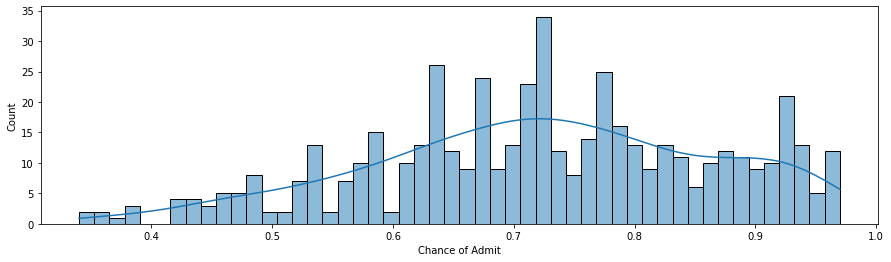

In [20]:
plt.figure(figsize=(15,4))
sns.histplot(data=df, x="Chance of Admit", bins=50, kde=True)

# (F) Bivariate Analysis

<AxesSubplot:xlabel='Research', ylabel='Chance of Admit'>

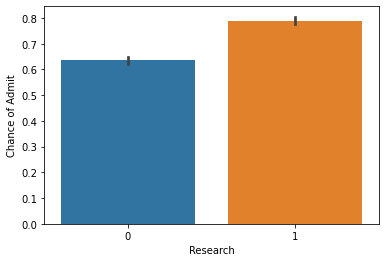

In [21]:
sns.barplot(data=df, x="Research", y="Chance of Admit")

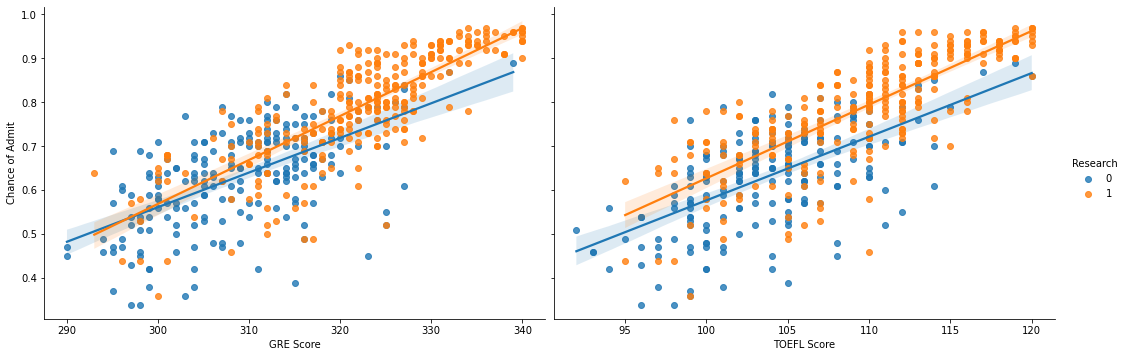

In [22]:
sns.pairplot(data=df, hue="Research", kind="reg", height=5, aspect=1.5,
             x_vars=['GRE Score', 'TOEFL Score'],
             y_vars=["Chance of Admit"]
)

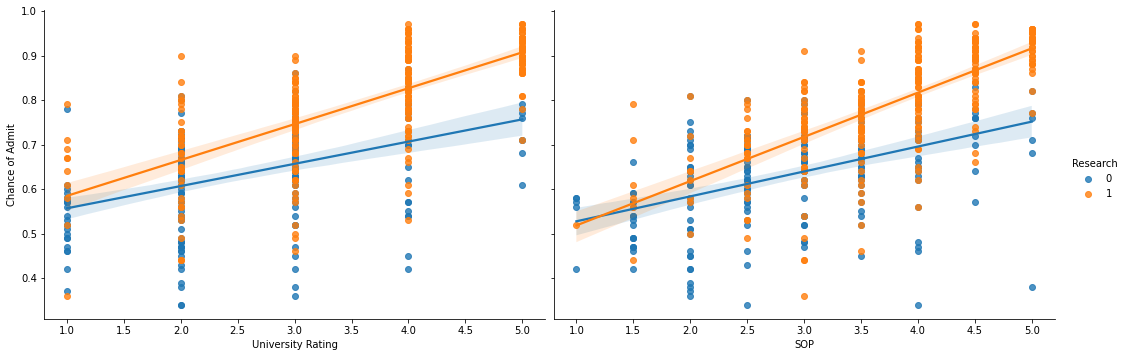

In [23]:
sns.pairplot(data=df, hue="Research", kind="reg", height=5, aspect=1.5,
             x_vars=['University Rating','SOP'],
             y_vars=["Chance of Admit"]
)

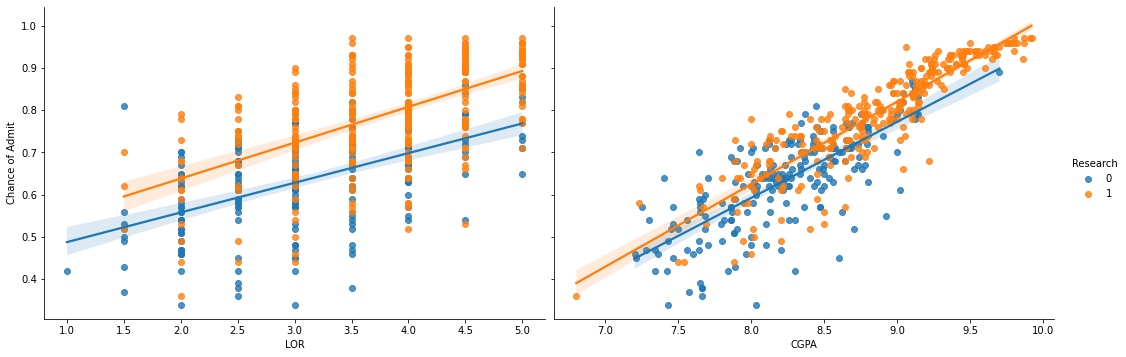

In [24]:
sns.pairplot(data=df, hue="Research", kind="reg", height=5, aspect=1.5,
             x_vars=['LOR', 'CGPA'],
             y_vars=["Chance of Admit"]
)

# (G) Linear regression model

In [25]:
df.shape

(500, 8)

In [26]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [27]:
X = df.iloc[:,0:-1].values; X

array([[337.  , 118.  ,   4.  , ...,   4.5 ,   9.65,   1.  ],
       [324.  , 107.  ,   4.  , ...,   4.5 ,   8.87,   1.  ],
       [316.  , 104.  ,   3.  , ...,   3.5 ,   8.  ,   1.  ],
       ...,
       [330.  , 120.  ,   5.  , ...,   5.  ,   9.56,   1.  ],
       [312.  , 103.  ,   4.  , ...,   5.  ,   8.43,   0.  ],
       [327.  , 113.  ,   4.  , ...,   4.5 ,   9.04,   0.  ]])

In [28]:
y = df.iloc[:,-1].values; y

array([0.92, 0.76, 0.72, 0.8 , 0.65, 0.9 , 0.75, 0.68, 0.5 , 0.45, 0.52,
       0.84, 0.78, 0.62, 0.61, 0.54, 0.66, 0.65, 0.63, 0.62, 0.64, 0.7 ,
       0.94, 0.95, 0.97, 0.94, 0.76, 0.44, 0.46, 0.54, 0.65, 0.74, 0.91,
       0.9 , 0.94, 0.88, 0.64, 0.58, 0.52, 0.48, 0.46, 0.49, 0.53, 0.87,
       0.91, 0.88, 0.86, 0.89, 0.82, 0.78, 0.76, 0.56, 0.78, 0.72, 0.7 ,
       0.64, 0.64, 0.46, 0.36, 0.42, 0.48, 0.47, 0.54, 0.56, 0.52, 0.55,
       0.61, 0.57, 0.68, 0.78, 0.94, 0.96, 0.93, 0.84, 0.74, 0.72, 0.74,
       0.64, 0.44, 0.46, 0.5 , 0.96, 0.92, 0.92, 0.94, 0.76, 0.72, 0.66,
       0.64, 0.74, 0.64, 0.38, 0.34, 0.44, 0.36, 0.42, 0.48, 0.86, 0.9 ,
       0.79, 0.71, 0.64, 0.62, 0.57, 0.74, 0.69, 0.87, 0.91, 0.93, 0.68,
       0.61, 0.69, 0.62, 0.72, 0.59, 0.66, 0.56, 0.45, 0.47, 0.71, 0.94,
       0.94, 0.57, 0.61, 0.57, 0.64, 0.85, 0.78, 0.84, 0.92, 0.96, 0.77,
       0.71, 0.79, 0.89, 0.82, 0.76, 0.71, 0.8 , 0.78, 0.84, 0.9 , 0.92,
       0.97, 0.8 , 0.81, 0.75, 0.83, 0.96, 0.79, 0.

In [29]:
X.shape

(500, 7)

In [30]:
y.shape

(500,)

#  Splitting the Data for Training and Testing

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 , random_state=40)

In [32]:
X_train

array([[326.  , 108.  ,   3.  , ...,   3.5 ,   8.89,   0.  ],
       [328.  , 115.  ,   4.  , ...,   4.  ,   9.16,   1.  ],
       [316.  , 105.  ,   2.  , ...,   2.5 ,   8.2 ,   1.  ],
       ...,
       [308.  , 101.  ,   2.  , ...,   4.  ,   7.9 ,   0.  ],
       [312.  , 104.  ,   3.  , ...,   3.5 ,   8.42,   0.  ],
       [299.  , 100.  ,   3.  , ...,   2.  ,   8.02,   0.  ]])

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

<mark>Feature scaling</mark>

In [35]:
X_train_scaled = StandardScaler().fit_transform(X_train)

In [36]:
model = LinearRegression()

In [37]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [38]:
model.coef_

array([0.02467479, 0.0228156 , 0.00839295, 0.00305268, 0.01421193,
       0.06267941, 0.00714737])

## model coefficients with column names

In [39]:
for i in range(len(model.coef_)):
    print(df.iloc[:,0:-1].columns[i],": ",model.coef_[i])

GRE Score :  0.024674785340424367
TOEFL Score :  0.022815595872619783
University Rating :  0.008392947684218815
SOP :  0.0030526791487475117
LOR :  0.014211927858252718
CGPA :  0.06267940700940168
Research :  0.007147369806552711


<strong>University Rating, SOP and research are not much important</strong>

<mark>Predictions</mark>

In [40]:
# Making predictions using the model
X_test_scaled = StandardScaler().fit_transform(X_test)
y_pred = model.predict(X_test_scaled)

<mark>Calculating score (Rsquare) for training and test</mark>

In [41]:
model.score(X_train_scaled, y_train)

0.821258066002903

In [42]:
model.score(X_test_scaled, y_test)

0.8119307122365182

# (H) Assumptions of linear regression

## Mean of residuals

In [43]:
y_test

array([0.64, 0.65, 0.68, 0.93, 0.53, 0.67, 0.76, 0.47, 0.7 , 0.39, 0.84,
       0.85, 0.49, 0.54, 0.76, 0.75, 0.46, 0.64, 0.65, 0.82, 0.68, 0.45,
       0.79, 0.62, 0.92, 0.77, 0.78, 0.93, 0.89, 0.57, 0.61, 0.64, 0.76,
       0.53, 0.78, 0.94, 0.65, 0.9 , 0.64, 0.87, 0.95, 0.72, 0.96, 0.78,
       0.64, 0.9 , 0.71, 0.92, 0.8 , 0.53, 0.71, 0.71, 0.91, 0.91, 0.89,
       0.89, 0.9 , 0.86, 0.56, 0.61, 0.87, 0.8 , 0.71, 0.72, 0.82, 0.54,
       0.78, 0.7 , 0.65, 0.93, 0.67, 0.72, 0.86, 0.63, 0.94, 0.7 , 0.69,
       0.49, 0.71, 0.66, 0.79, 0.65, 0.75, 0.65, 0.77, 0.57, 0.64, 0.93,
       0.7 , 0.62, 0.82, 0.96, 0.91, 0.93, 0.71, 0.7 , 0.54, 0.76, 0.93,
       0.73, 0.71, 0.71, 0.56, 0.82, 0.76, 0.75, 0.76, 0.92, 0.63, 0.79,
       0.87, 0.47, 0.45, 0.83, 0.75, 0.37, 0.51, 0.64, 0.77, 0.61, 0.34,
       0.59, 0.66, 0.62, 0.56, 0.73, 0.82, 0.86, 0.55, 0.58, 0.64, 0.75,
       0.52, 0.65, 0.71, 0.62, 0.85, 0.72, 0.83, 0.78, 0.73, 0.64, 0.92,
       0.6 , 0.79, 0.78, 0.42, 0.95, 0.36, 0.58])

In [44]:
y_pred = model.predict(X_test)

In [45]:
np.mean(y_test-y_pred)

-10.869596041231107

## Linearity of variables (no pattern in residual plot)

Text(0, 0.5, 'ytest-ypred')

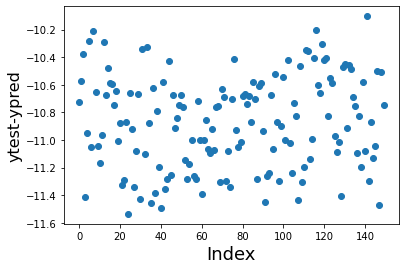

In [46]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.scatter(c,y_test-y_pred)
# fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)

Text(0, 0.5, 'ytest-ypred')

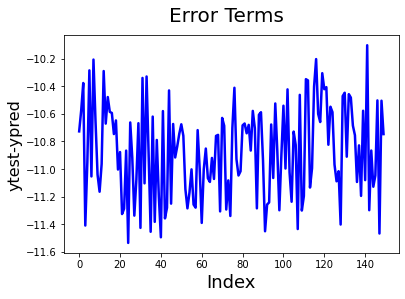

In [47]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)

## Test for Homoscedasticity

Text(0, 0.5, 'ytest-ypred')

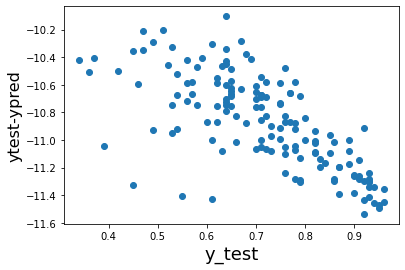

In [48]:
# Error terms
# c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.scatter(y_test, y_test-y_pred)
# fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)

## Normality of residuals

<AxesSubplot:ylabel='Count'>

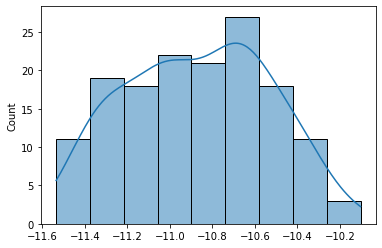

In [49]:
sns.histplot(data=y_test-y_pred, kde=True)

In [50]:
from scipy.stats import skew, shapiro

In [51]:
skew(y_test-y_pred)

-0.004157264617527331

In [52]:
# H0 = residuals are normally distributed
# H1 = residuals are not nomally distributed
shapiro(y_test-y_pred)

ShapiroResult(statistic=0.9781555533409119, pvalue=0.017223479226231575)

<strong>since pvalue=0.00044 < 0.05, hence H0 is rejected. Residuals are not normal</strong>

# (I) Testing **VIF**
- Though we see that most of the features are statistically significant,
- There might be MultiCollinearity amongst them.



So we will perform a VIF just for a Sanity check

In [53]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [54]:
vif = pd.DataFrame()
X_t = df.loc[:,('GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA','Research')]
vif['Features'] = X_t.columns
vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,GRE Score,1308.06
1,TOEFL Score,1215.95
5,CGPA,950.82
3,SOP,35.27
4,LOR,30.91
2,University Rating,20.93
6,Research,2.87


In [55]:
import statsmodels.api as sm
X_new = df.loc[:,('GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA','Research')]
X_new_scaled = StandardScaler().fit_transform(X_new)
X2_sm = sm.add_constant(X_new_scaled)  #Statmodels default is without intercept, to add intercept we need to add constant 

sm_model = sm.OLS(df['Chance of Admit'], X2_sm).fit() #fit y,X
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     324.4
Date:                Tue, 03 Jan 2023   Prob (F-statistic):          8.21e-180
Time:                        23:32:49   Log-Likelihood:                 701.38
No. Observations:                 500   AIC:                            -1387.
Df Residuals:                     492   BIC:                            -1353.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7217      0.003    269.039      0.0

# Testing score by removing high VIF and low pvalue columns

In [56]:
# checking score by removing GRE Score column

In [57]:
vif = pd.DataFrame()
X_t = df.loc[:,('TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA','Research')]
vif['Features'] = X_t.columns
vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,CGPA,728.78
0,TOEFL Score,639.74
2,SOP,33.73
3,LOR,30.63
1,University Rating,19.88
5,Research,2.86


In [58]:
import statsmodels.api as sm
X_new = df.loc[:,('TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA','Research')]
X_new_scaled = StandardScaler().fit_transform(X_new)
X2_sm = sm.add_constant(X_new_scaled)  #Statmodels default is without intercept, to add intercept we need to add constant 

sm_model = sm.OLS(df['Chance of Admit'], X2_sm).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     366.7
Date:                Tue, 03 Jan 2023   Prob (F-statistic):          3.46e-178
Time:                        23:32:49   Log-Likelihood:                 694.52
No. Observations:                 500   AIC:                            -1375.
Df Residuals:                     493   BIC:                            -1346.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7217      0.003    265.642      0.0

In [59]:
# checking score by removing GRE Score,SOP columns

In [60]:
vif = pd.DataFrame()
X_t = df.loc[:,('TOEFL Score', 'University Rating', 'LOR', 'CGPA','Research')]
vif['Features'] = X_t.columns
vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,CGPA,718.83
0,TOEFL Score,637.69
2,LOR,27.31
1,University Rating,15.34
4,Research,2.84


In [61]:
import statsmodels.api as sm
X_new = df.loc[:,('TOEFL Score', 'University Rating', 'LOR', 'CGPA','Research')]
X_new_scaled = StandardScaler().fit_transform(X_new)
X2_sm = sm.add_constant(X_new_scaled)  #Statmodels default is without intercept, to add intercept we need to add constant 

sm_model = sm.OLS(df['Chance of Admit'], X2_sm).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     440.9
Date:                Tue, 03 Jan 2023   Prob (F-statistic):          1.61e-179
Time:                        23:32:50   Log-Likelihood:                 694.50
No. Observations:                 500   AIC:                            -1377.
Df Residuals:                     494   BIC:                            -1352.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7217      0.003    265.898      0.0

In [62]:
# checking score by removing GRE Score, SOP, University rating columns

In [63]:
vif = pd.DataFrame()
X_t = df.loc[:,('TOEFL Score', 'LOR', 'CGPA','Research')]
vif['Features'] = X_t.columns
vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,CGPA,700.60
0,TOEFL Score,629.32
1,LOR,22.98
3,Research,2.67


In [64]:
import statsmodels.api as sm
X_new = df.loc[:,('TOEFL Score', 'LOR', 'CGPA','Research')]
X_new_scaled = StandardScaler().fit_transform(X_new)
X2_sm = sm.add_constant(X_new_scaled)  #Statmodels default is without intercept, to add intercept we need to add constant 

sm_model = sm.OLS(df['Chance of Admit'], X2_sm).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     547.1
Date:                Tue, 03 Jan 2023   Prob (F-statistic):          4.23e-180
Time:                        23:32:50   Log-Likelihood:                 692.59
No. Observations:                 500   AIC:                            -1375.
Df Residuals:                     495   BIC:                            -1354.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7217      0.003    265.155      0.0

<mark>Score of model did not change much by removing columns with high VIF and low pvalue </mark>

# (J) Ridge regression with k-cross-validation

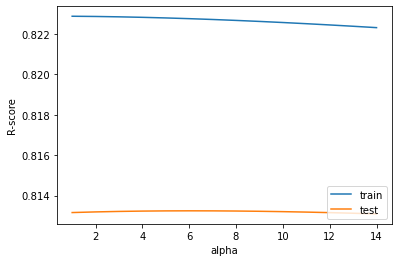

In [66]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

alphas = 15
train_scores = []
test_scores = []

for alpha in range(1, alphas):
    fold_train_scores = []
    fold_test_scores = []

    for train_index, test_index in kf.split(X): #iterating through the K-folds
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        ridge_model = make_pipeline(StandardScaler(), Ridge(alpha))
        ridge_model.fit(X_train, y_train) #training model
        
        train_score = ridge_model.score(X_train, y_train)
        test_score = ridge_model.score(X_test, y_test)
        
        fold_train_scores.append(train_score) 
        fold_test_scores.append(test_score)

    train_score = np.mean(fold_train_scores) 
    test_score = np.mean(fold_test_scores)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure()
plt.plot(list(range(1, alphas)), train_scores, label="train")
plt.plot(list(range(1, alphas)), test_scores, label="test")
plt.legend(loc='lower right')
plt.xlabel("alpha")
plt.ylabel("R-score")
plt.show()

# (K) Lasso regression with k-cross-validation

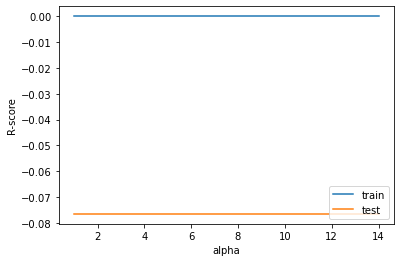

In [67]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

alphas = 15
train_scores = []
test_scores = []

for alpha in range(1, alphas):
    fold_train_scores = []
    fold_test_scores = []

    for train_index, test_index in kf.split(X): #iterating through the K-folds
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        ridge_model = make_pipeline(StandardScaler(), Lasso(alpha))
        ridge_model.fit(X_train, y_train) #training model
        
        train_score = ridge_model.score(X_train, y_train)
        test_score = ridge_model.score(X_test, y_test)
        
        fold_train_scores.append(train_score) 
        fold_test_scores.append(test_score)

    train_score = np.mean(fold_train_scores) 
    test_score = np.mean(fold_test_scores)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure()
plt.plot(list(range(1, alphas)), train_scores, label="train")
plt.plot(list(range(1, alphas)), test_scores, label="test")
plt.legend(loc='lower right')
plt.xlabel("alpha")
plt.ylabel("R-score")
plt.show()

# (L) Actionable insights

- <strong>University Rating, SOP and research are not much important in predicting the chance of admit</strong>
- <strong>Chance of admit is highly dependent on CGPA</strong>
- <strong>GRE and TOEFL scores are second most deciding factor after CGPA</strong>

# (M) Recommendations

- Institute should give more attention to the students who have average CGPA to increase their chance of admit

# ------------------------X-------------------------------X----------------------------------- #

# Metric  analysis

Note: Metrics analysis over MAE is missing from the report

- Note: Metrics analysis over RMSE is missing from the report

- Note: Metrics analysis over R2 is missing from the report

- Note: Metrics analysis over Adj R2 is missing from the report

- Note: You should split in training and test and then comment on the metrics

- Note: This step with a detailed explanation is missing:

-> Comments on the performance measures and if there is any need to improve the model or not

# Actionable Insights & Recommendations?

You missed to answer the following pointers:

-> Comments on significance of predictor variables

-> Comments on additional data sources for model improvement, model implementation in the real world,

potential business benefits from improving the model (These are key to differentiating a good and an excellent solution)

- Note that we were expecting these types of recommendations:

(NOTE: They will differ based on the data preprocessing and feature engineering you have performed, but should be along these lines)

-> Country is an important factor and should be added to the data. For example, an Indian Student even with a high score will have a low chance of an ivy league compared to an African student.

-> `Since University Rating and SOP strength have no statistical importance in predicting the chance of admission they can be removed from the website.`

-> `Since CGPA has the highest importance as compared to all other features, a further study can be made to find the threshold of CGPA required for admissions`

-> `Research experience has the least importance in contributing to chances of admission and hence can be made an optional field or can even be omitted.`

-> <mark>GRE score, TOEFL score, and strength of LOR have the same weightage for Chance of admission and students can be advised that a very high score in one can cover for low score in others.</mark>

-> `These insights and predictions have an accuracy of around 81% and this may be because of a lack of data. The same study must be performed with a significantly larger dataset for more accurate insights`

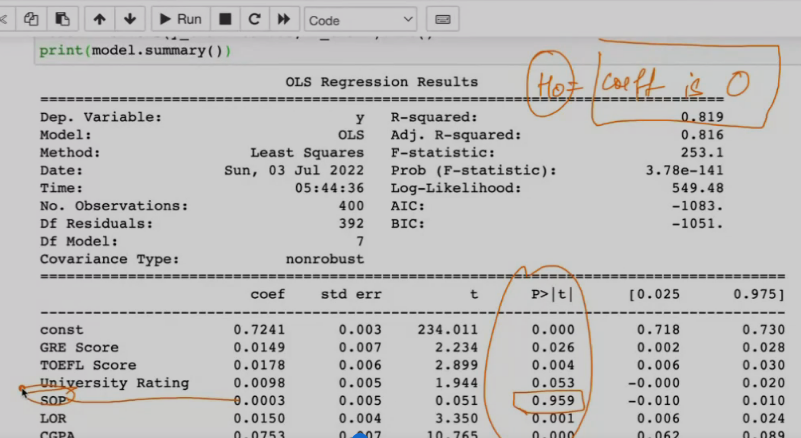

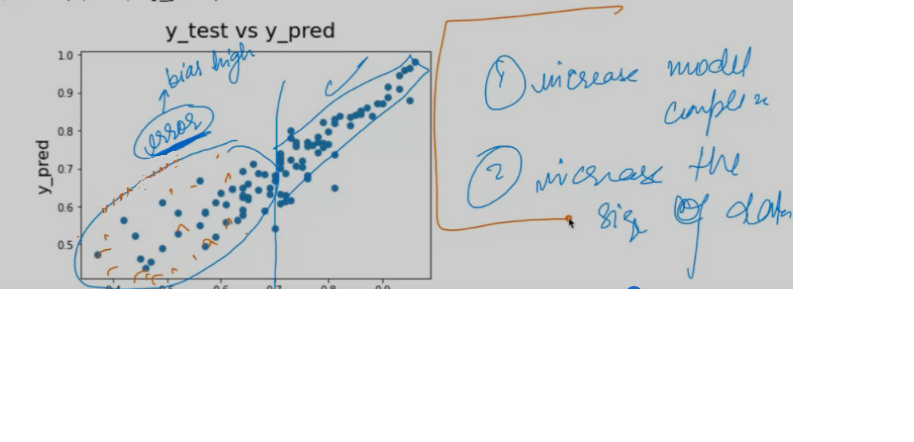